# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# import torchvision.transforms as Transforms
# from torchvision.transforms import ToTensor

# Functions

In [2]:
def plot_data(data):
    """
    Plots values for Open, Close, High, Low, Volume, Turnover over the selected time period
    data: pd DataFrame
    """
    data_local = data.copy(abs)
    data_local['month'] = data_local['Date'].dt.month
    sns.set(style = "whitegrid")
    cols = ['Open', 'Close', 'High', 'Low', 'Volume', 'Turnover']
    fig, ax = plt.subplots(nrows = 3, ncols = 2, sharex=True, figsize=(12,10))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(x = 'Date', y = cols[i], data = data_local, ax=ax)
        ax.tick_params(axis="x", rotation=90, labelsize=10, length=0)

    fig.tight_layout()
    plt.show()

In [3]:
# def create_sequences(data, seq_length):
#     '''
#     Arguments:
#     data: dataframe containing data
#     seq_length: Length of each sequence

#     Returns:
#     in_seqs: numpy array of sequences of each day
#     t_vals: numpy array of sequences of the next day's close price
#     '''
#     # data = data[['Open','Close','High','Low']].to_numpy()
#     np_data = data[['Close']].to_numpy()
#     in_seqs, t_vals, scalers = [], [], []
#     for i in range(len(data) - seq_length):
#         scaler = MinMaxScaler(feature_range=(0,1))
#         in_seq, t_val = np_data[i:i+seq_length], np_data[i+seq_length]
#         in_seq
#         in_seqs.append(in_seq)
#         t_vals.append(t_val)
#     return np.array(in_seqs), np.array(t_vals)

In [7]:
def create_sequences(data, seq_length):
    '''
    Arguments:
    data: dataframe containing data
    seq_length: Length of each sequence

    Returns:
    in_seqs: numpy array of sequences of each day
    t_vals: numpy array of sequences of the next day's close price
    '''
    # data = data[['Open','Close','High','Low']].to_numpy()
    # np_data = data[['Close']].to_numpy()
    in_seqs, t_vals, scalers = [], [], []
    for i in range(len(data) - seq_length):
        scaler = MinMaxScaler(feature_range=(0,1))
        # in_seq, t_val = data['Close'][i:i+seq_length], data['Close'][i+seq_length]
        reg = data['Close'][i:i+seq_length+1]
        scaled_reg = scaler.fit_transform(reg.values.reshape(-1,1))
        in_seq = scaled_reg[:-1]
        t_val = scaled_reg[-1]
        in_seqs.append(in_seq)
        t_vals.append(t_val)
        scalers.append(scaler)
        # print(in_seq.shape, t_val.shape)
    return np.array(in_seqs), np.array(t_vals), scalers

In [64]:
def custom_collate(batch):
    sequences, targets, scalers = zip(*batch)
    sequences = torch.stack(sequences)
    targets = torch.stack(targets)
    return sequences, targets, scalers

# Exploring the Data

In [4]:
df = pd.read_csv("NIFTY 50 24-05-2015 to 24-05-2024.csv", parse_dates=['Date'])
df

,Date,Open,High,Low,Close,Volume,Turnover
0,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17
1,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47
2,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44
3,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55
4,2015-11-16,7732.95,7838.85,7714.15,7806.60,154134885.0,6871.15
...,...,...,...,...,...,...,...
2117,2024-05-18,22512.85,22520.25,22470.05,22502.00,19064566.0,1572.77
2118,2024-05-21,22404.55,22591.10,22404.55,22529.05,347591587.0,30782.35
2119,2024-05-22,22576.60,22629.50,22483.15,22597.80,290345590.0,28556.14
2120,2024-05-23,22614.10,22993.60,22577.45,22967.65,369767547.0,39157.65


There are 2120 data points in the dataset, corresponding to 24 years of stock price data.

In [5]:
len(df)

2122

Dates are stored as pandas datetime objects for ease of use in visualisation and performing aggregations

In [6]:
df.loc[0]['Date']

Timestamp('2015-11-09 00:00:00')

In [7]:
type(df.loc[0]['Date'])

pandas._libs.tslibs.timestamps.Timestamp

In [8]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Turnover'], dtype='object')

Turnover is measured in crore Rs.

In [9]:
cols = list(df.columns)
for col in cols:
    print(f"\nColumn: {col}")
    print(f"dtype: {df[col].dtype}")
    print(f"All vals are not null: {df[col].notnull().all()}")


Column: Date
dtype: datetime64[ns]
All vals are not null: True

Column: Open
dtype: float64
All vals are not null: True

Column: High
dtype: float64
All vals are not null: True

Column: Low
dtype: float64
All vals are not null: True

Column: Close
dtype: float64
All vals are not null: True

Column: Volume
dtype: float64
All vals are not null: False

Column: Turnover
dtype: float64
All vals are not null: False


There are null values for the fields "Volume" and "Turnover". There are several methods to replace null values with numerical values, but as I will not be using thesse fields, I will not be doing so at this time.

## Visualising data of past 1000 days:

C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

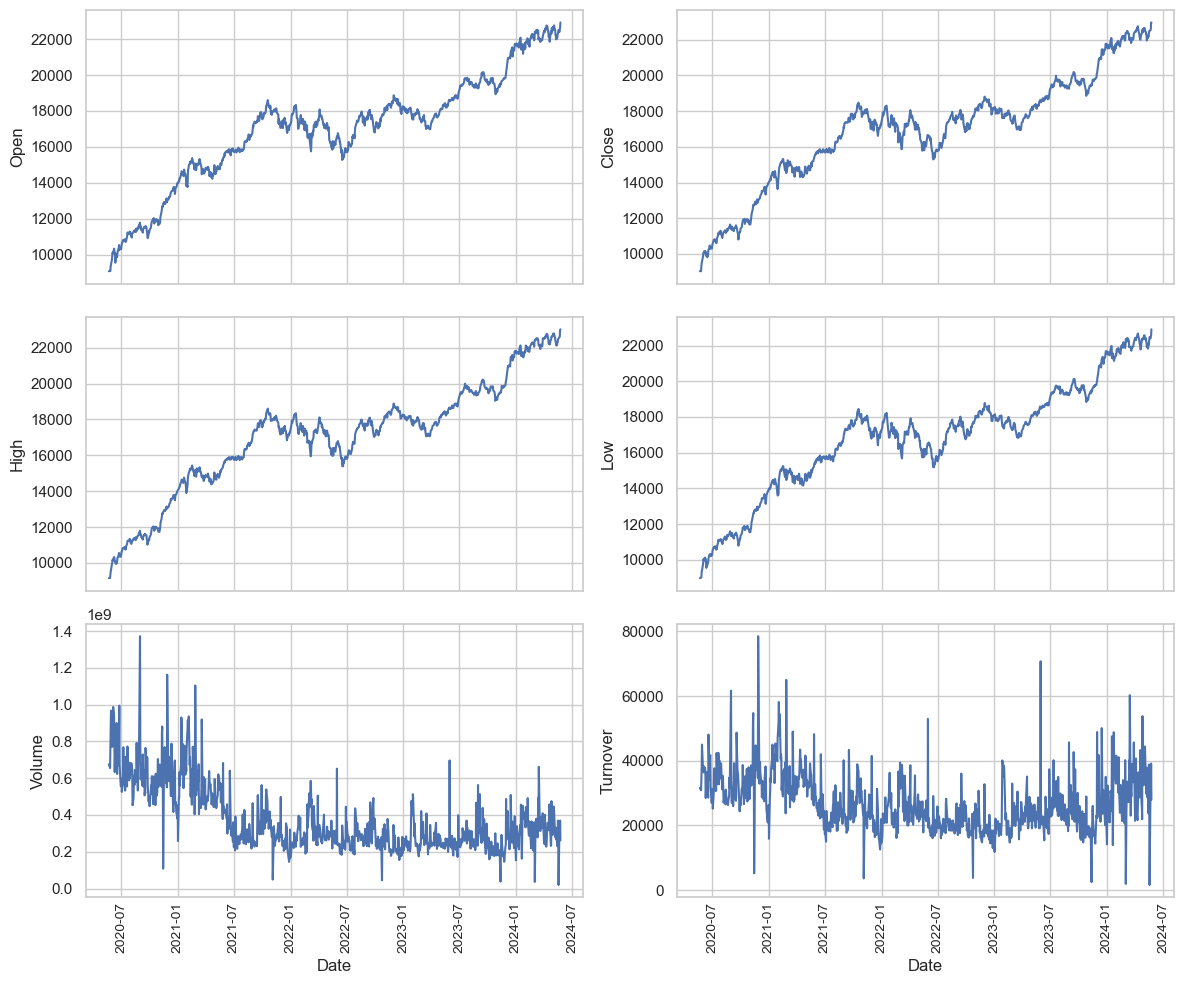

In [10]:
test_1000_df = df.iloc[-1000:]

plot_data(test_1000_df)

## Visualising data of past 90 days:

C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

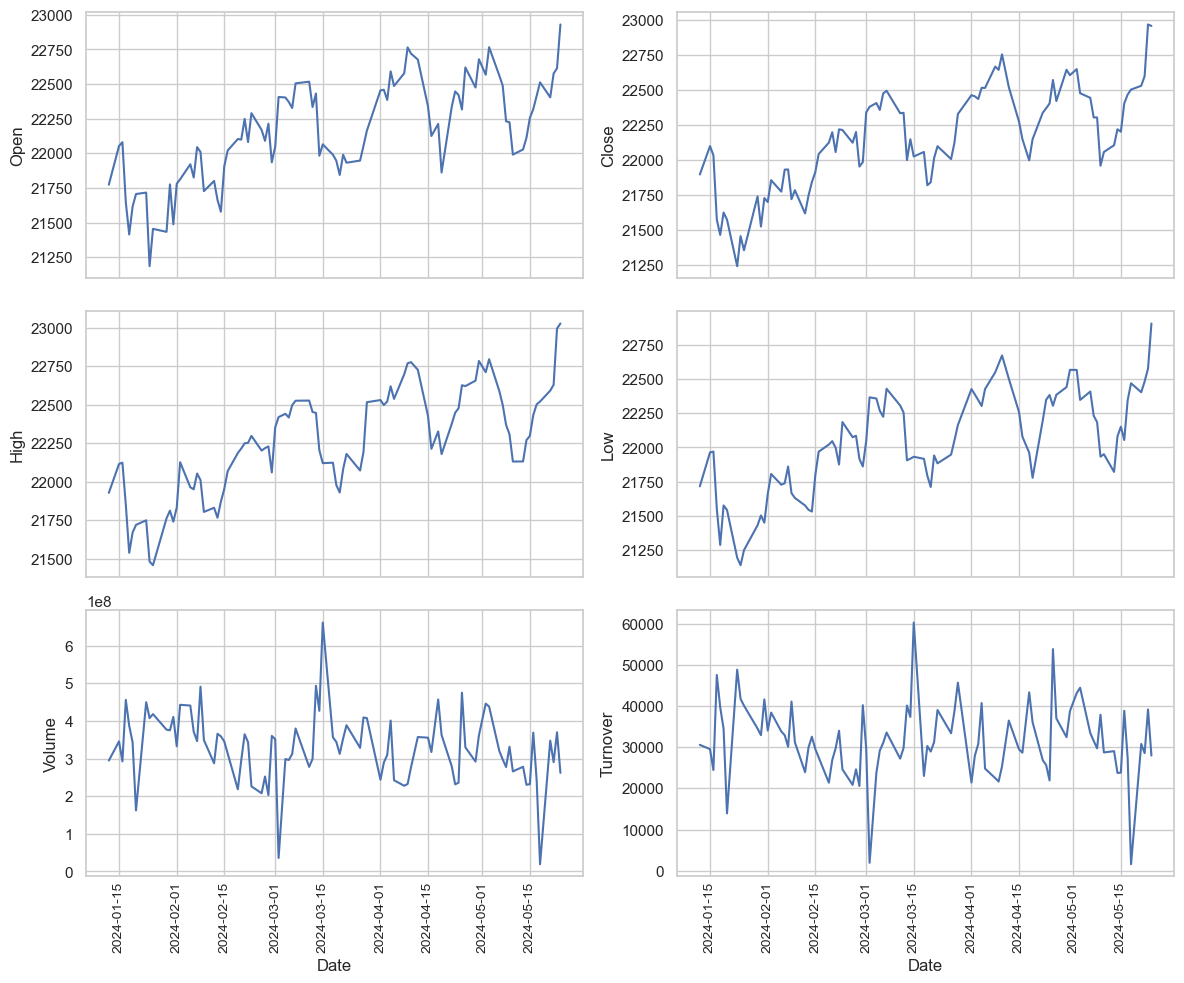

In [11]:
test_90_df = df.iloc[-90:]

plot_data(test_90_df)

# Load and normalize the data

In [5]:
df = pd.read_csv("NIFTY 50 24-05-2015 to 24-05-2024.csv", parse_dates=['Date'])
df

,Date,Open,High,Low,Close,Volume,Turnover
0,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17
1,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47
2,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44
3,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55
4,2015-11-16,7732.95,7838.85,7714.15,7806.60,154134885.0,6871.15
...,...,...,...,...,...,...,...
2117,2024-05-18,22512.85,22520.25,22470.05,22502.00,19064566.0,1572.77
2118,2024-05-21,22404.55,22591.10,22404.55,22529.05,347591587.0,30782.35
2119,2024-05-22,22576.60,22629.50,22483.15,22597.80,290345590.0,28556.14
2120,2024-05-23,22614.10,22993.60,22577.45,22967.65,369767547.0,39157.65


In [68]:
# seqs, targets,scalers = create_sequences(df, 60, test = True)
# print(seqs.shape, targets.shape, len(scalers))

(2062, 60, 1) (2062, 1) 2062


Visualise data after transformation

C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

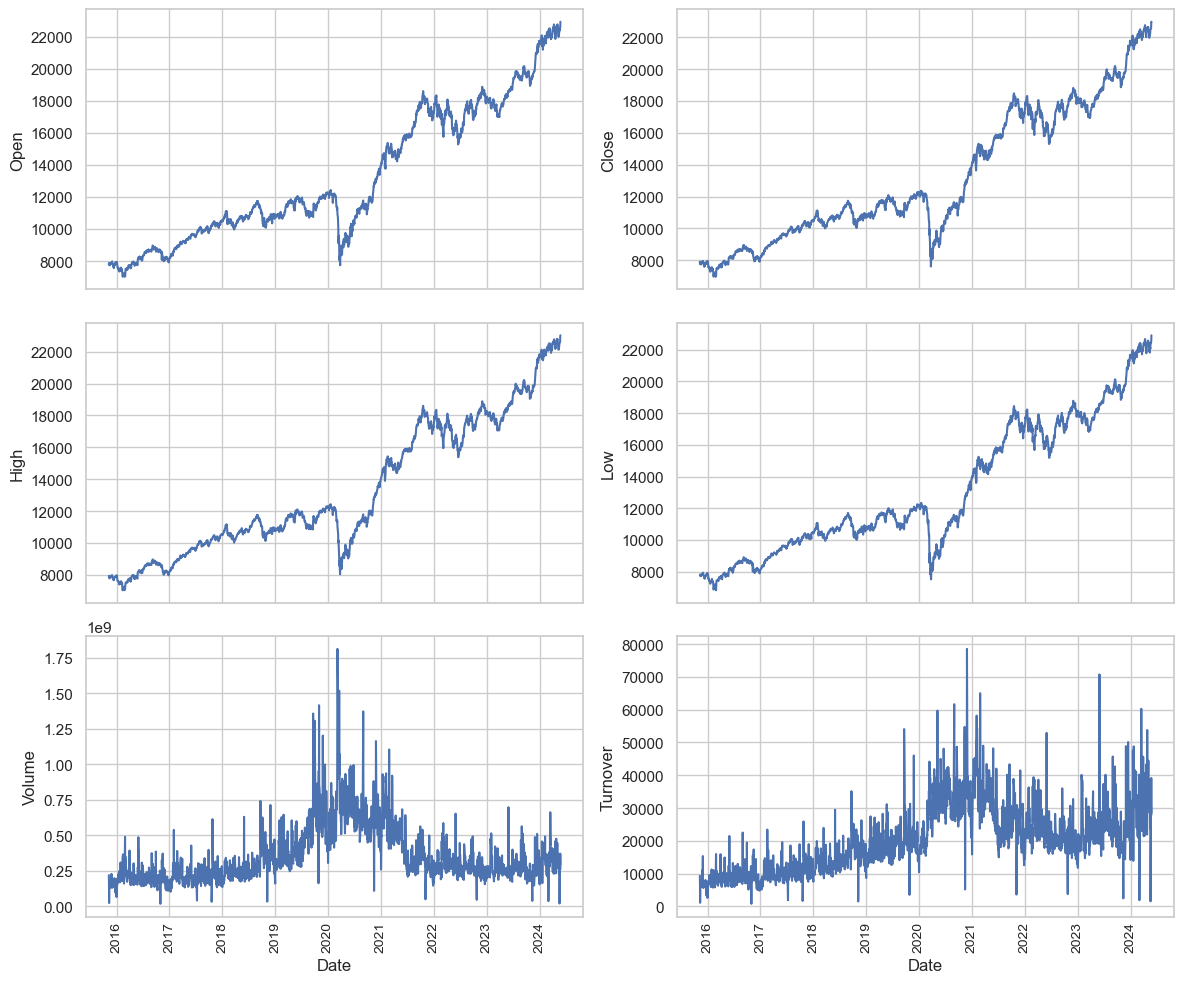

In [63]:
plot_data(df)

# Custom Dataset

In [56]:
class CustomDataset(Dataset):
    def __init__(self, data,seq_length):
        """
        Args: 
        data - pd Dataframe containing data
        """
        self.sequences, self.targets, self.scalers = create_sequences(data, seq_length)
        print(self.sequences.shape, self.targets.shape)
    def __len__(self):
        return len(self.sequences)
        
    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype = torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32).view(-1)
        scaler = self.scalers[idx]
        return sequence, target, scaler

## Datasets:

In [51]:
seq_length =60

There 2122 data points in the dataset. I will use the first 1700 as training data, the next 200 as validation data, and the last 222 as test data 

In [52]:
# train_df = df[:-180]
# val_df = df[-180:-90]
# test_df = df[-90:]

In [53]:
train_df = df[:-90]
test_df = df[-90:]


## Plotting each dataset

C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

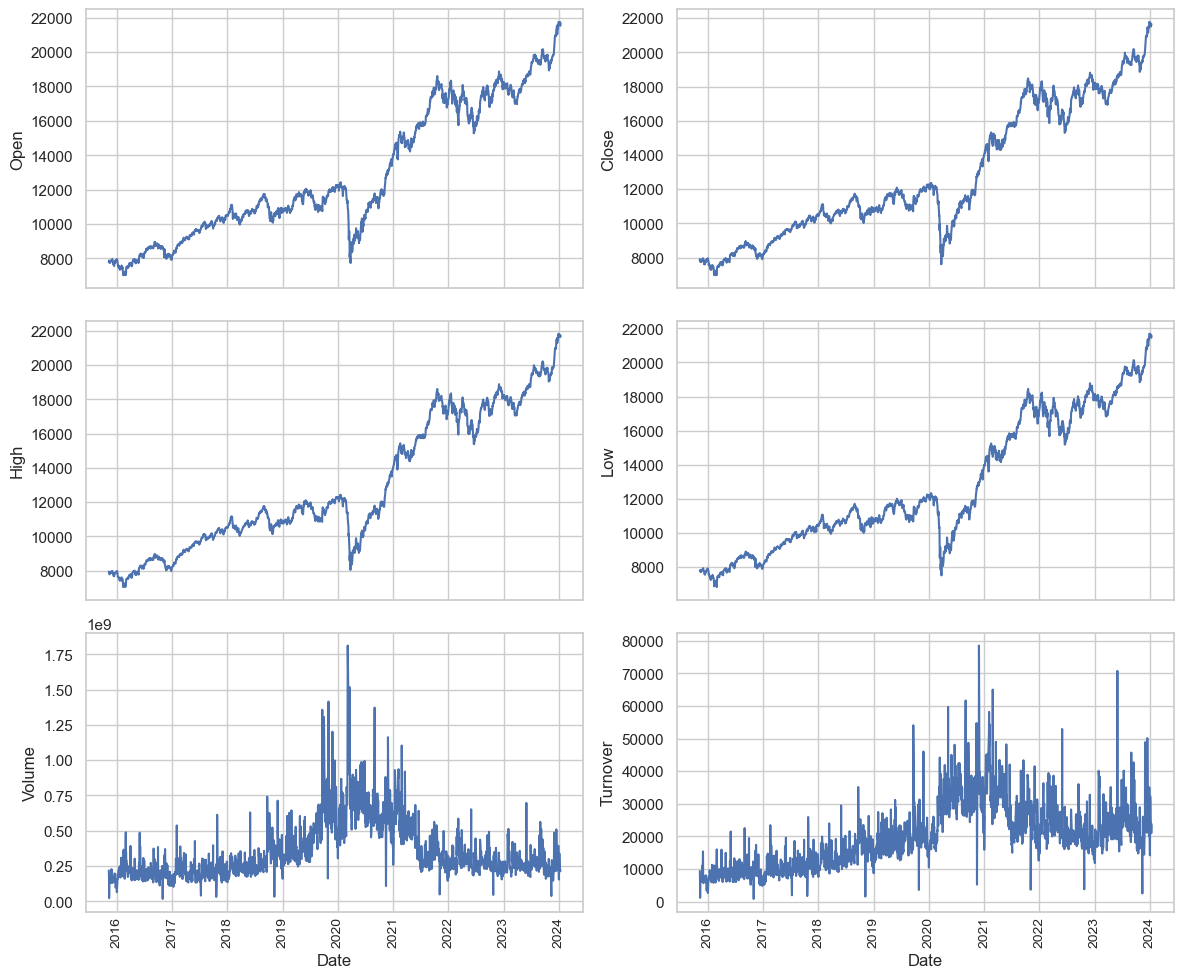

In [30]:
plot_data(train_df)

In [32]:
# plot_data(val_df)

C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\arvin\anaconda3\envs\torch_Env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

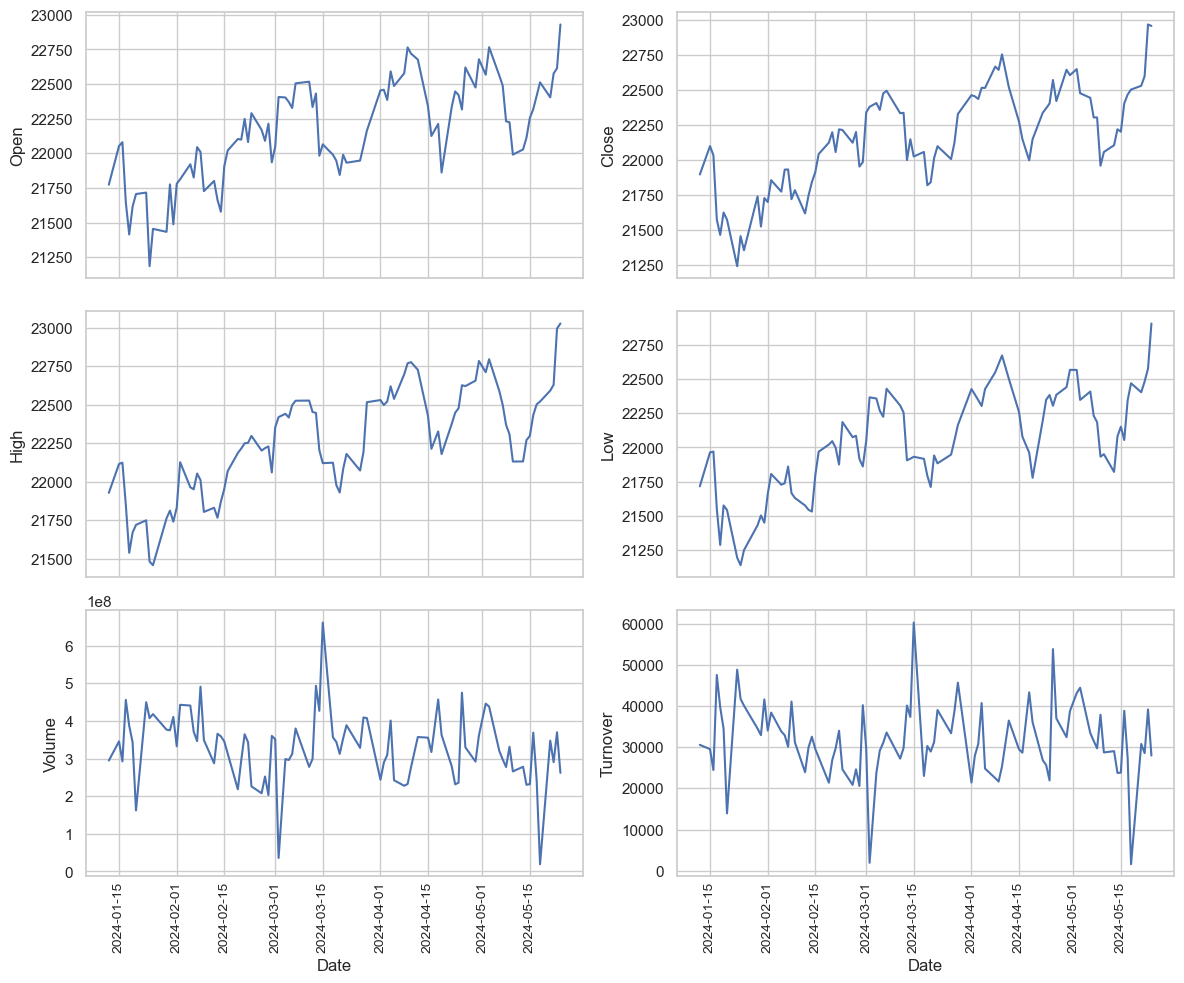

In [34]:
plot_data(test_df)

## Creating datasets

In [35]:
# train_ds = CustomDataset(train_df,seq_length)
# val_ds = CustomDataset(val_df, seq_length)
# test_ds = CustomDataset(test_df, seq_length)

In [57]:
train_ds = CustomDataset(train_df,seq_length)
test_ds = CustomDataset(test_df, seq_length)

(1972, 60, 1) (1972, 1)
(30, 60, 1) (30, 1)


## Dataloaders:

In [58]:
batch_size = 64

In [59]:
# train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

In [65]:
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

## Dataloader Test:

In [66]:
for idx, data in enumerate(train_dataloader):
    print(idx)
    print(type(data[0]), type(data[1]))
    print(data[0].shape, data[1].shape)
    print(data[0])
    print(data[1])
    break

0
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([64, 60, 1]) torch.Size([64, 1])
tensor([[[0.8434],
         [0.7701],
         [0.7974],
         ...,
         [0.6688],
         [0.6551],
         [0.7392]],

        [[0.0644],
         [0.0967],
         [0.0989],
         ...,
         [1.0000],
         [0.9342],
         [0.9288]],

        [[0.5244],
         [0.5215],
         [0.4669],
         ...,
         [0.0754],
         [0.0442],
         [0.1499]],

        ...,

        [[0.0000],
         [0.0359],
         [0.0254],
         ...,
         [0.6796],
         [0.5454],
         [0.5416]],

        [[0.9665],
         [1.0000],
         [0.9031],
         ...,
         [0.5385],
         [0.4829],
         [0.3663]],

        [[0.1100],
         [0.0701],
         [0.0000],
         ...,
         [0.9267],
         [1.0000],
         [0.9625]]])
tensor([[0.8958],
        [0.8915],
        [0.0000],
        [0.7965],
        [0.0000],
        [0.7823],
      

# Model Architecture

In [67]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).requires_grad_()
        
        # print(x.shape, h0.shape, c0.shape)
        x, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        x = self.fc(x[:, -1, :])
        return x

# Training

In [75]:
input_size = 1 # Number of features
hidden_size = 64 # No of units in hidden layers
num_layers = 3 # No of hidden layers
output_size = 1 # No of output features

In [76]:
model = LSTMModel(input_size = input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers)

In [77]:
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [78]:
if(torch.cuda.is_available):
    print("Using cuda")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using cuda


In [79]:
model = model.to(device)

In [80]:
num_epochs = 50

criterion=nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for _, (seqs, targets, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        seqs = seqs.to(device)
        targets = targets.to(device)

        outputs = model(seqs)
        # print("\n",seqs.shape, targets.shape, outputs.shape)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        # print(running_loss)
    losses.append(running_loss/len(train_dataloader))

    # model.eval()
    # running_val_loss = 0.0
    # with torch.inference_mode():
    #     for _, (seqs, targets) in enumerate(val_dataloader):
    #         seqs = seqs.to(device)
    #         targets = targets.to(device)
    #         outputs = model(seqs)
    #         loss = criterion(outputs, targets)
    #         running_val_loss+=loss.item()
    #     val_losses.append(running_val_loss/len(val_dataloader))
    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.74it/s]


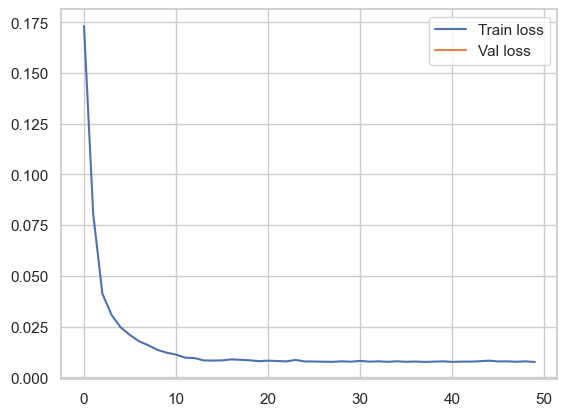

In [81]:
plt.plot(losses, label = "Train loss")
plt.plot(val_losses, label = "Val loss")
# plt.legend(['Train loss', 'Val loss'])
plt.legend()
plt.show()

# Evaluation and Testing

In [92]:
running_test_loss = 0.0
model.eval()
scalers_test = []
plot_targs = []
plot_preds = []
with torch.inference_mode():
    for _, (seqs, targets,scalers) in enumerate(test_dataloader):
        # for seq in seqs:
        #     print(seq.shape)
        #     plot_seqs.append(seq[-1,0].cpu().numpy())
        seqs = seqs.to(device)
        targets = targets.to(device)
        preds = model(seqs)
        
        scalers_test.extend(scalers)

        target = targets.cpu().numpy()
        plot_targs.extend(target)
        preds_cpu = preds.cpu().numpy()
        plot_preds.extend(preds_cpu)
        
        loss = criterion(preds, targets)
    avg_loss = loss/len(test_dataloader.dataset)
print(f"Test loss: {avg_loss.item()}")
print(len(plot_targs), len(plot_preds), len(scalers_test))

Test loss: 0.0005751786520704627
30 30 30


In [93]:
print(plot_targs)

[array([1.], dtype=float32), array([0.8452805], dtype=float32), array([0.6823102], dtype=float32), array([0.600066], dtype=float32), array([0.49970296], dtype=float32), array([0.5994719], dtype=float32), array([0.72448844], dtype=float32), array([0.74534655], dtype=float32), array([0.74921495], dtype=float32), array([0.8690765], dtype=float32), array([0.7289519], dtype=float32), array([0.9103678], dtype=float32), array([0.8690837], dtype=float32), array([0.90718526], dtype=float32), array([0.755702], dtype=float32), array([0.7265656], dtype=float32), array([0.6033399], dtype=float32), array([0.6033399], dtype=float32), array([0.30010986], dtype=float32), array([0.3859811], dtype=float32), array([0.42891672], dtype=float32), array([0.46964523], dtype=float32), array([0.40914187], dtype=float32), array([0.62626153], dtype=float32), array([0.6927431], dtype=float32), array([0.73108345], dtype=float32), array([0.7599722], dtype=float32), array([0.83339566], dtype=float32), array([1.], dtyp

In [94]:
scaled_preds = []
scaled_targets = []
for i in range(len(scalers_test)):
    scaler = scalers_test[i]
    scaled_pred = scaler.inverse_transform(plot_targs[i].reshape(-1,1))
    scaled_target = scaler.inverse_transform(plot_preds[i].reshape(-1,1))
    scaled_preds.append(scaled_pred)
    scaled_targets.append(scaled_target)
    
scaled_preds=np.array(scaled_preds).flatten()
scaled_targets=np.array(scaled_targets).flatten()

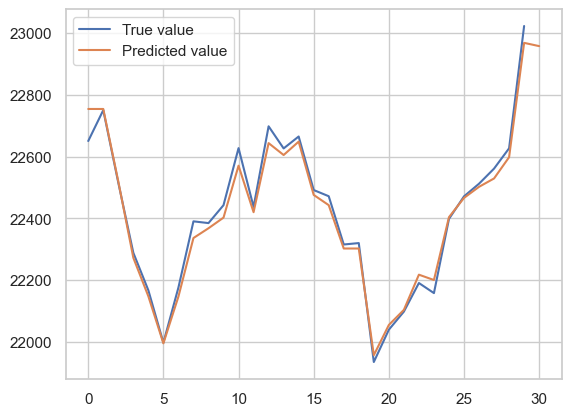

In [97]:
sc_pred = [scaled_preds[0]]
sc_pred.extend(scaled_preds)
plt.plot(scaled_targets, label = "True value")
plt.plot(sc_pred, label = "Predicted value")
plt.legend()
plt.show()

# Unrelated Sample